# Rozpoznawanie obrazów
Projekt został wykonany na zajęciach Rozpoznawanie Obrazów na 4 semestrze studiów na kierunku Inżynieria Systemów na Politechnice Wrocławskiej. Zajęcia prowadził dr inż. Maciej Zięba. Prowadzący zapewnił dane.

### Cel projektu
Celem projektu jest porównanie różnych metod uczenia maszynowego w rozpoznawaniu obrazów

### Opis
Dane zawierają 60000 obrazów ukazujązych różne części garderoby. Każdy obraz jest rozmiaru 36x36 pikseli. Obrazy są podzielone na 10 klas. Dla utrudnienia zadania prowadzący dodał szum i wykonał drobne przesunięcia obiektów, któe znajdują się na zdjęciach.<br/>

W projekcie zostaną zaimplementowane dwie metody uczenia maszynowego od początku:
- Logistic Regression 
- K-Nearest Neighbors

Oraz siedem metod przy użyciu biblioteki tensorflow i scikit-learn:
- Convolutional Neural Network
- Multilayer Perceptron
- Decision Tree
- Random Forest
- XGBoost
- Support Vector Machine
- Naive Bayes

#### Import potrzebnych bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

### Załadowanie oraz wyświetlenie potrzebnych danych

In [2]:
path = open("data.pkl", "rb")
data = pkl.load(path)

print("Ilość obrazów:\n" + str(len(data[0])) + '\n')
print("Przykładowe dane:\n" + str(data[0][:2]) + '\n')
print("Przykładowe etykiety:\n" + str(data[1][:2]))

Ilość obrazów:
60000

Przykładowe dane:
[[0.08759263 0.44399702 0.11604331 ... 0.13489278 0.02033333 0.09685737]
 [0.18683595 0.047415   0.31967908 ... 0.18845089 0.38688332 0.04445307]]

Przykładowe etykiety:
[7 7]


### Wyświetlenie przykładowych obrazów

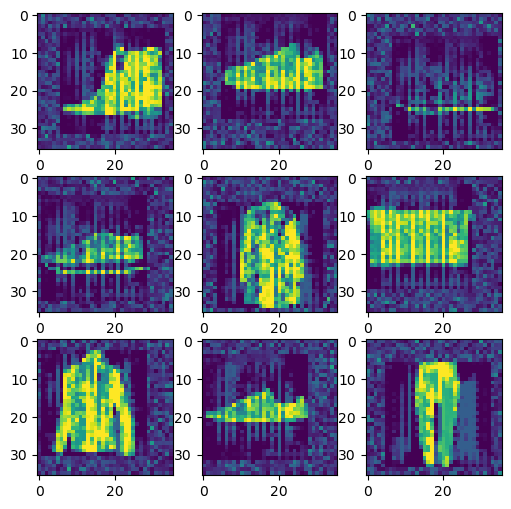

In [3]:
rows = 3
columns = 3

plt.style.use('default')

fig = plt.figure(figsize=(6, 6))

for i in range(rows * columns):
    image = data[0][i].reshape(36, 36)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(image)
    
plt.show()

### Podział danych na zbiór treningowy i testowy

In [4]:
train_size = 0.8
quantity_of_train_data = int(len(data[0]) * train_size)

x_train = data[0][: quantity_of_train_data]
y_train = data[1][: quantity_of_train_data]

x_test = data[0][quantity_of_train_data :]
y_test = data[1][quantity_of_train_data :]

# Logistic Regression
Program korzysta z softmax (potrzebne do wieloklasowej regresji logistycznej) oraz regularyzacji

In [5]:
def change(list_of_numbers):
    '''Funkcja przyjmuje listę cyfr ze zbioru 0,..,9 i zwraca listę 
    zawierającą listy 10 elementowe które mają 1 na miejscu odpowiadającej 
    im cyfry i zera na pozostałych miejscach'''
    
    change_list = np.eye(10, 10)
    changed_numbers = []
    change_function = lambda a: change_list[a]
    
    for i in range(len(list_of_numbers)):
        changed_numbers.append(list(change_function(list_of_numbers[i])))
        
    return changed_numbers


def softmax(z):
    '''Funkcja zwraca prawdopodobieństwa
    przynależności do danej klasy'''
    
    sm = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
    
    return sm


def loss_function(w, x, y, lam):
    '''Funkcja straty'''

    m = x.shape[0]
    y_changed = change(y)
    scores = np.dot(x, w)
    prob = softmax(scores)
    loss = (-1 / m) * np.sum(y_changed * np.log(prob)) + (lam / 2) * np.sum(w * w) # Funkcja straty z regularyzacją
    grad = (-1 / m) * np.dot(x.T,(y_changed - prob)) + lam * w # Gradient funkcji straty  (1296,10)

    return loss, grad


def prediction(x, w):
    '''Funkcja zwracająca prognozowaną klasę'''

    prob = softmax(np.dot(x, w))
    pred = np.argmax(prob, axis=1)
    
    return pred


def success(y_pred, y_test):
    '''Funkcja licząca trafność prognozowanych klas'''

    accuracy = sum(y_pred == y_test) / (len(y_test)) * 100

    return round(accuracy, 2)

### Ustawienie parametrów i uczenie modelu

In [6]:
def fit(lam=0.01, iterations=100, learning_rate=0.1):

    # ustanowienie początkowych wag
    w = np.zeros((x_train.shape[1], len(np.unique(y_train))))

    loss_list = np.zeros((iterations, 1))

    for i in range(iterations):
        loss, grad = loss_function(w, x_train, y_train, lam)
        w = w - (learning_rate * grad)
        
        if i % 50 == 0:
            print("Iteracja: "+ str(i))
            print("Wartość funkcji straty: " + str(round(loss, 2)))
        loss_list[i] = loss
    
    return w, loss_list


lam = 0.01 # Parametr regularyzacji
iterations = 500 # Liczba iteracji
learning_rate = 0.12

w, loss_list = fit(lam, iterations, learning_rate)

Iteracja: 0
Wartość funkcji straty: 2.3
Iteracja: 50
Wartość funkcji straty: 1.34
Iteracja: 100
Wartość funkcji straty: 1.21
Iteracja: 150
Wartość funkcji straty: 1.15
Iteracja: 200
Wartość funkcji straty: 1.12
Iteracja: 250
Wartość funkcji straty: 1.1
Iteracja: 300
Wartość funkcji straty: 1.09
Iteracja: 350
Wartość funkcji straty: 1.08
Iteracja: 400
Wartość funkcji straty: 1.08
Iteracja: 450
Wartość funkcji straty: 1.07


### Przebieg funkcji straty

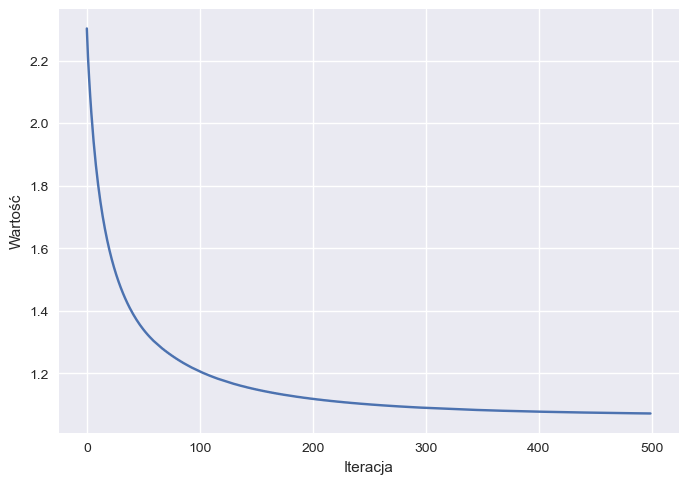

In [7]:
plt.style.use('seaborn')
plt.plot(loss_list)
plt.xlabel('Iteracja')
plt.ylabel('Wartość')
plt.show()

### Predykcja klas dla zbioru testowego oraz obliczenie trafności prognoz

In [8]:
y_pred = prediction(x_test, w)
score = success(y_pred, y_test)

wyniki = {}
wyniki['Logistic Regression'] = score

print('Logistic Regression success: ', str(score) + ' %')

Logistic Regression success:  68.47 %


# K-Nearest Neighbors


In [9]:
def most_frequent(x):
    '''Funkcja zwracająca najczęściej występującą wartość w liście'''
    
    return max(set(x), key = x.count)


def predict_KNN(x_train, y_train, x_test, k=5):
    """Funkcja pobierająca dane treningowe i testowe.
    Zwraca listę prognozowanych klas.
    K - liczba najbliższych sąsiadów"""

    y_pred = []

    for j in range(len(x_test)):
        macierz_odleglosci = []
        etykiety = []
        
        # Liczenie odległości pomiędzy obrazem testowym, a obrazami treningowymi
        for i in range(len(x_train)):
            odleglosc = np.sum((x_train[i] - x_test[j]) ** 2)
            macierz_odleglosci.append(odleglosc)
            
        posortowana_macierz = sorted(macierz_odleglosci)
        
        # Dodanie do listy etykiety k klas, które są najbliżej obrazu testowego
        for i in range(k):
            etykiety.append(y_train[macierz_odleglosci.index(posortowana_macierz[i])])

        # Dodanie predykcji do y_pred (najczęściej występującego elementu z najbliższych odległości)
        y_pred.append(most_frequent(etykiety))

    return y_pred

### Predykcja klas dla zbioru testowego oraz obliczenie trafności prognoz
Ze względu na dużą złożoność obliczeniową, tylko 500 przykładów jest wykorzystywanych ze zbioru treningowego

In [10]:
y_pred = predict_KNN(x_train[:500], y_train[:500], x_test, k=5)
score = success(y_pred, y_test)

wyniki['K-NN'] = score
print('K-NN success: ', str(score) + ' %')

K-NN success:  56.91 %


# Convolutional Neural Network

In [11]:
train_images = []
val_images = []
test_images = []
train_labels = np.reshape(np.array(y_train[8000:]), (40000, 1))
val_labels = np.reshape(np.array(y_train[:8000]), (8000, 1))
test_labels = np.reshape(np.array(y_test), (12000, 1))

for i in range(8000,len(x_train)):
    train_images.append(np.reshape(np.array(x_train[i]), (36,36,1)))
    
for i in range(8000):
    val_images.append(np.reshape(np.array(x_train[i]), (36,36,1)))
    
for i in range(len(x_test)):
    test_images.append(np.reshape(np.array(x_test[i]), (36,36,1)))

train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(36, 36, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 34, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Train on 40000 samples, validate on 8000 samples
Epoch 1/10
40000/40000 [==============================] - 48s 1ms/sample - loss: 0.6905 - accuracy: 0.7441 - val_loss: 0.5764 - val_accuracy: 0.7835
Epoch 2/10
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.5096 - accuracy: 0.8128 - val_loss: 0.4581 - val_accuracy: 0.8320
Epoch 3/10
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.4324 - accuracy: 0.8432 - val_loss: 0.4258 - val_accuracy: 0.8441
Epoch 4/10
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.3801 - accuracy: 0.8604 - val_loss: 0.4127 - val_accuracy: 0.8541
Epoch 5/10
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.3416 - accuracy: 0.8755 - val_loss: 0.3956 - val_accuracy: 0.8602
Epoch 6/10
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.3094 - accuracy: 0.8866 - val_loss: 0.4040 - val_accuracy: 0.8575
Epoch 7/10
40000/40000 [==============================] -

12000/12000 - 4s - loss: 0.4679 - accuracy: 0.8518


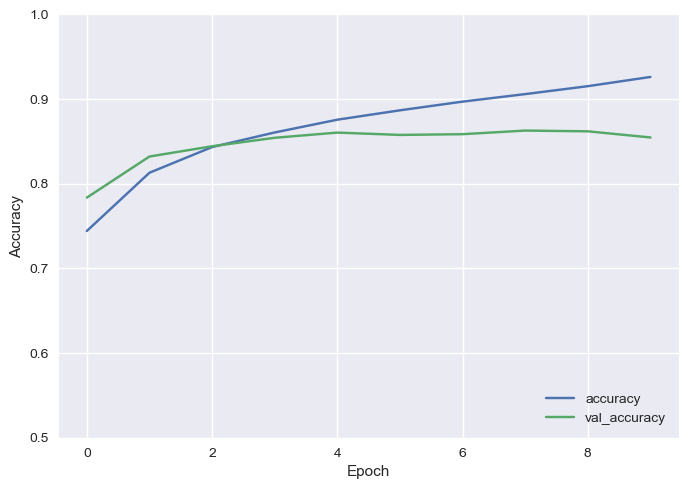

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [16]:
wyniki['CNN'] = test_acc * 100

print('Convolutiona Neural Network success: ', str(test_acc * 100) + ' %')

Convolutiona Neural Network success:  85.17500162124634 %


# Multilayer Perceptron

In [17]:
def train_and_predict_MLP(x_train, y_train, x_test):

    mlp = MLPClassifier(hidden_layer_sizes=(100,))
    mlp.fit(x_train, y_train)
    y_pred = mlp.predict(x_test)

    return y_pred

In [18]:
y_pred = train_and_predict_MLP(x_train, y_train, x_test)
score = success(y_pred, y_test)
wyniki['MLP'] = score

print('MLP success: ', str(score) + ' %')

MLP success:  77.74 %


# Decision Tree

In [19]:
def train_and_predict_tree(x_train, y_train, x_test):

    tree = DecisionTreeClassifier()
    tree.fit(x_train, y_train)
    y_pred = tree.predict(x_test)

    return y_pred

In [20]:
y_pred = train_and_predict_tree(x_train, y_train, x_test)
score = success(y_pred, y_test)
wyniki['Decision Tree'] = score

print('Decision Tree success: ', str(score) + ' %')

Decision Tree success:  59.78 %


# Random Forest

In [21]:
def train_and_predict_forest(x_train, y_train, x_test):

    random_forest = RandomForestClassifier()
    random_forest.fit(x_train, y_train)
    y_pred = random_forest.predict(x_test)

    return y_pred

In [22]:
y_pred = train_and_predict_forest(x_train, y_train, x_test)
score = success(y_pred, y_test)
wyniki['Random Forest'] = score

print('Random Forest: ', str(score) + ' %')

Random Forest:  78.28 %


# XGBoost

In [23]:
def train_and_predict_xgboost(x_train, y_train, x_test):

    xgboost = XGBClassifier(n_estimators=50, eval_metric="mlogloss", use_label_encoder=False)
    xgboost.fit(x_train, y_train)
    y_pred = xgboost.predict(x_test)

    return y_pred

In [25]:
y_pred = train_and_predict_xgboost(x_train[:15000], y_train[:15000], x_test)
score = success(y_pred, y_test)
wyniki['XGBoost'] = score

print('XGBoost: ', str(score) + ' %')

XGBoost:  76.1 %


# Support Vector Machine

In [26]:
def train_and_predict_svm(x_train, y_train, x_test):

    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)

    return y_pred

In [27]:
y_pred = train_and_predict_svm(x_train[:10000], y_train[:10000], x_test)
score = success(y_pred, y_test)
wyniki['SVM'] = score

print('SVM: ', str(score) + ' %')

SVM:  76.98 %


# Naive Bayes

In [28]:
def train_and_predict_bayes(x_train, y_train, x_test):

    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    y_pred = gnb.predict(x_test)
    
    return y_pred

In [29]:
y_pred = train_and_predict_tree(x_train, y_train, x_test)
score = success(y_pred, y_test)
wyniki['Naive Bayes'] = score

print('Naive Bayes success: ', str(score) + ' %')

Naive Bayes success:  60.15 %


### Przedstawienie na wykresie osiągniętych wyników

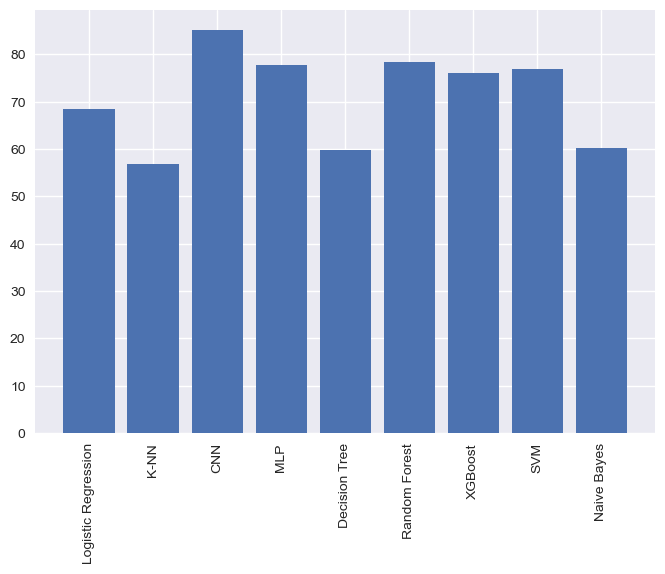

In [30]:
plt.bar(range(len(wyniki)), list(wyniki.values()), align='center')
plt.xticks(range(len(wyniki)), list(wyniki.keys()), rotation='vertical')
plt.show()

## Wyniki
Jak możemy zauważyć, Konwolucyjna sieć neuronowa poradziła sobie najlepiej z rozpoznawaniem obrazów. Miała on wynik na poziomie 85 %. Bardzo podobnie poradziły sobie modele MLP, Random Forest, XGBoost oraz SVM. Uzyskały one wynik w okolicach 77 %. Gorzej poradziła sobie regresja logistyczna - z wynikiem 68,5 %. Decision Tree oraz Naive Bayes uzyskały wyniki koło 60 %.